<div class="alert alert-success">
<b>Reviewer's comment V2</b>

The project is accepted! Keep up the good work on the next sprint! 

</div>

**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job overall, but there is one small problem that needs to be fixed before the project is accepted. Let me know if you have questions!

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

# Introduction
Background:
- The Sweet Lift Taxi company operates a fleet of taxis at airports and seeks to optimize its operations by predicting taxi demand. Accurately forecasting the number of taxi orders for the next hour is crucial for aligning driver availability with passenger needs, thereby improving service levels and maximizing efficiency.

Objectives:
- The primary goal of this project is to develop a machine learning model that can predict the number of taxi orders at airports for the upcoming hour. The model's predictions are intended to help the company better manage its fleet during peak times and ensure a balance between supply and demand.

- Data Preparation and Preprocessing:
    - The data was resampled to an hourly frequency to match the prediction intervals.
    - Preliminary data analysis was performed to understand the dataset's characteristics and to identify any cleaning or transformation needs.

- Model Evaluation:
    - The models were evaluated using the RMSE metric, with a performance target set to achieve an RMSE of less than 48 on the test set.




## Preparation

In [110]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [111]:
# Load the data
try:
    df = pd.read_csv('./datasets/taxi.csv')
except:
    df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/taxi.csv')

In [112]:
# Convert the 'datetime' column to datetime type (if not already done)
df['datetime'] = pd.to_datetime(df['datetime'])
df.info()
df.sample(5)

In [113]:
# Set the 'datetime' column as the index
df.set_index('datetime', inplace=True)

# Resample the data by one hour, aggregating with the sum of orders
df= df.resample('1H').sum()

# Display the first few rows to verify the resampling
print(df.head())

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was resampled correctly

</div>

## Analysis

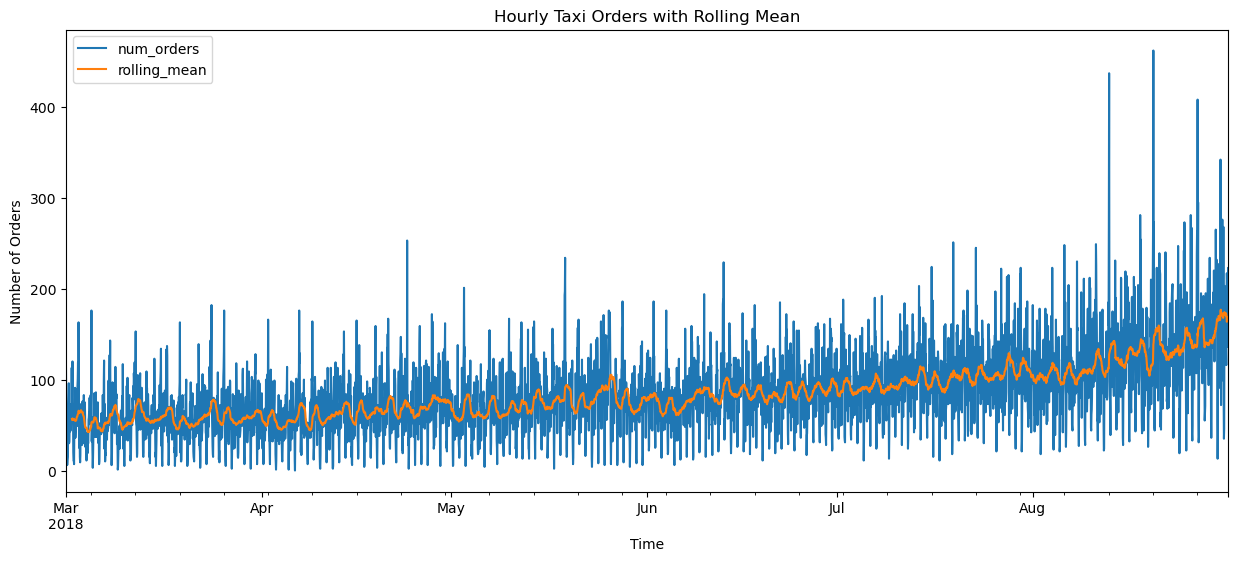

In [114]:
# Applying a rolling mean for smoothing
df['rolling_mean'] = df['num_orders'].rolling(window=24).mean()

# Plot the rolling mean
df[['num_orders', 'rolling_mean']].plot(figsize=(15, 6))
plt.title('Hourly Taxi Orders with Rolling Mean')
plt.xlabel('Time')
plt.ylabel('Number of Orders')
plt.show()

The plot above shows the hourly taxi orders over the given time period. From this visualization, we can observe some key points:

- There appears to be a repeating pattern, suggesting daily seasonality in taxi orders. This means there are specific hours within the day when the demand for taxis increases significantly.
- There are noticeable spikes in orders at certain points, which could indicate special events or specific days of the week when demand is particularly high.

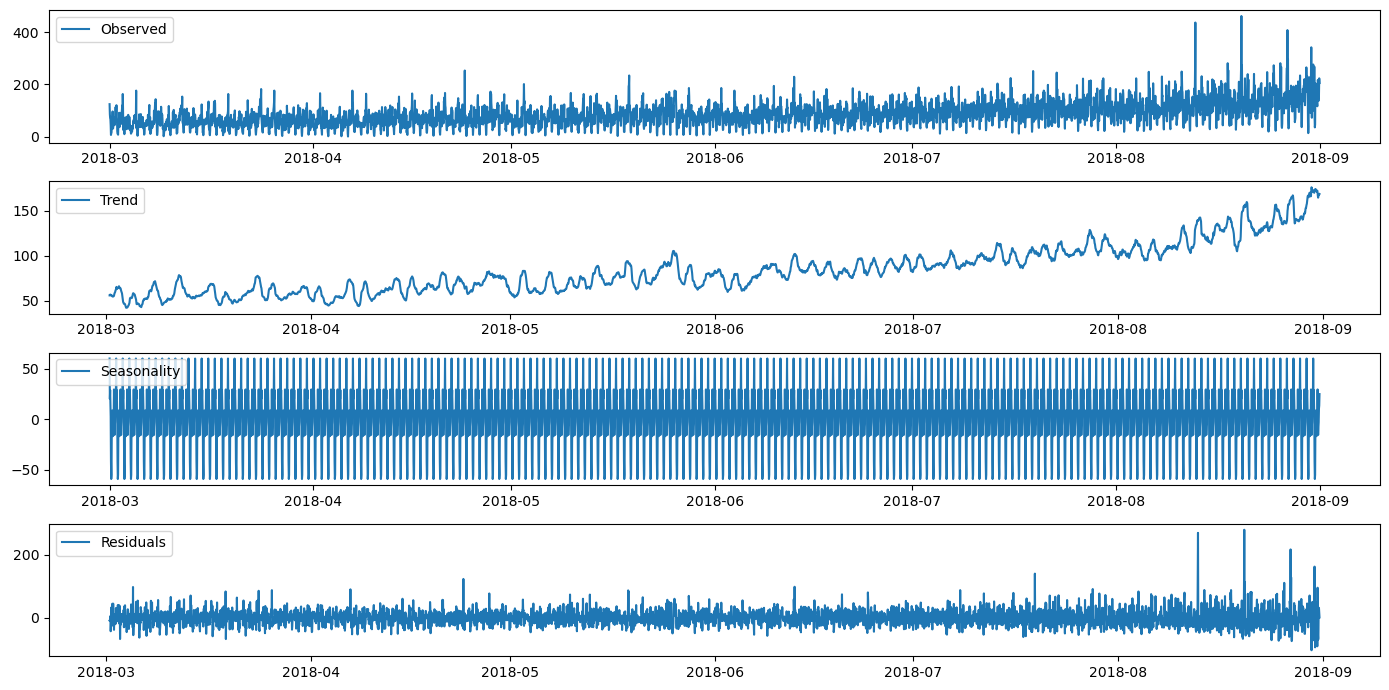

In [115]:
# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(df['num_orders'], model='additive')

# Plot the decomposed components
plt.figure(figsize=(14, 7))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

The decomposition of the time series into trend, seasonality, and residuals allows us to understand different components influencing the taxi orders data. Here's what can be concluded from each graph:

- Observed (Original Time Series): This graph shows the actual hourly taxi orders over time. The overall pattern suggests variability in demand, with some periods showing higher orders than others. The observed data includes all components of the time series: trend, seasonality, and any irregularities or noise.

- Trend: The trend component smooths out the series to highlight the long-term direction or pattern in the data. From the trend graph, we can observe periods where the demand for taxis is increasing or decreasing over time. The trend seems to be going up, which indicates that over time throughout the data, the demand for taxis increased.

- Seasonality: This component captures the regular, predictable cycles or fluctuations in the data that repeat over a known period, such as daily or weekly. The seasonality graph clearly shows the daily cycle of demand, with specific times of day experiencing higher orders consistently. This pattern is crucial for planning and resource allocation, indicating peak hours when more taxis are needed.

- Residuals: The graph of residuals helps us understand the extent of random noise or unexplained variability in the taxi orders. There is no clear observable pattern in the graph.


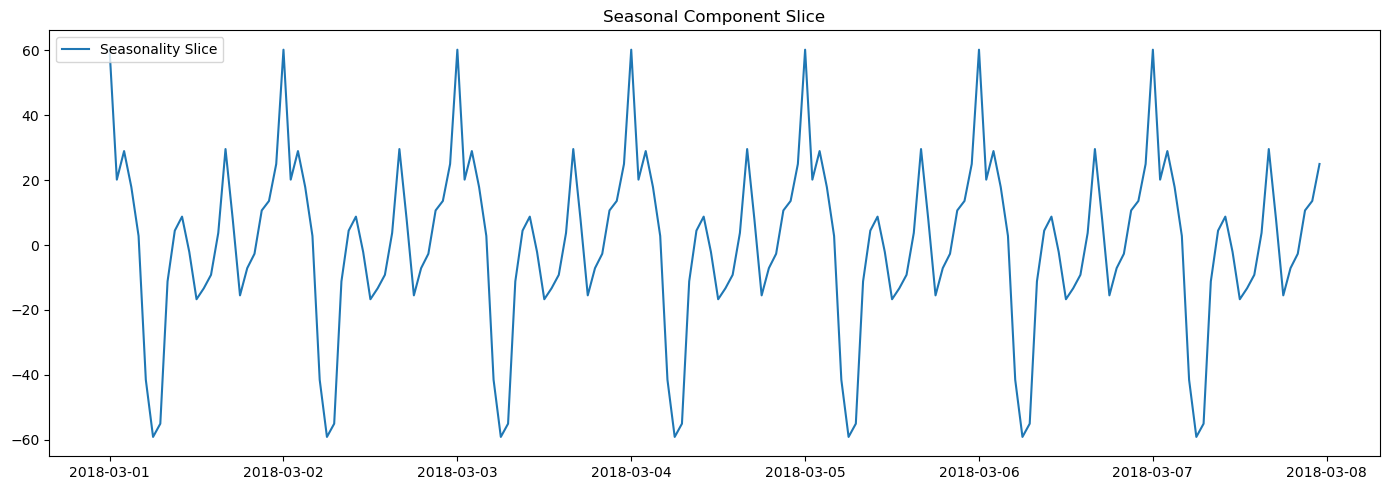

In [125]:
# Choose a slice of the seasonal component
seasonal_slice = decomposition.seasonal['2018-03-01':'2018-03-07']  # Adjust dates to your dataset

plt.figure(figsize=(14, 5))
plt.plot(seasonal_slice, label='Seasonality Slice')
plt.legend(loc='upper left')
plt.title('Seasonal Component Slice')
plt.tight_layout()
plt.show()

The plot of the seasonal component slice from March 1st to March 7th, 2018, shows clear daily periodicity, indicating that the number of orders has a regular daily pattern. This could be linked to people's daily routines, such as commuting, resulting in peaks and troughs corresponding to rush hours and off-peak times. The amplitude of the fluctuations provides insight into the variation in demand throughout each day.

<div class="alert alert-warning">
<b>Reviewer's comment</b>

I would suggest looking at a smaller slice of `decomposition.seasonal` to better see the pattern :)

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Awesome!

</div>

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you visualized the data and the rolling mean and did a seasonal decomposition.

</div>

## Training

In [117]:
# Features
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

# Apply the feature engineering function
make_features(df, 24, 5)

# Drop the NaN values created by lag and rolling features
df.dropna(inplace=True)

# Splitting the data into training (90%) and test (10%) sets
# Since it's time series data, we'll use shuffle=False to maintain the chronological order
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(df.drop('num_orders', axis=1), 
                                                    df['num_orders'], 
                                                    shuffle=False, 
                                                    test_size=0.1)

# Display the shapes of the training and test sets to verify
(X_train.shape, X_test.shape), (y_train.shape, y_test.shape)

<div class="alert alert-success">
<b>Reviewer's comment</b>

The features look good: you added calendar features, lag features and a shifted rolling mean

</div>

In [118]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to the test data
X_test_scaled = scaler.transform(X_test)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Scaling was applied correctly

</div>

In [119]:
def evaluate_model_time_series(model, X, y):
    rmse_scores = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        rmse = sqrt(mean_squared_error(y_test, predictions))
        rmse_scores.append(rmse)
    
    average_rmse = sum(rmse_scores) / len(rmse_scores)
    return average_rmse

In [120]:
X = np.concatenate((X_train_scaled, X_test_scaled))
y = np.concatenate((y_train, y_test))

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Regular k-fold cross-validation is not suitable for time series models: in all folds but one validation and train data are mixed. To avoid that problem you can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) (to use it with GridSearchCV you can just pass an object of this class as the `cv` parameter)

</div>

<div class="alert alert-info">
<b>Student's comment</b>

Based on your feedback, I've adapted the models for time series analysis by employing TimeSeriesSplit for cross-validation. This approach ensures that the chronological order of the data is maintained, allowing us to evaluate the models' performance more accurately in a time series context. This includes not only the Decision Tree but also Ridge Regression, Lasso Regression, and CatBoost, aligning all models with the temporal nature of our dataset. Moreover, I've transitioned to using average RMSE as our metric. This change provides a more comprehensive view of model performance over time.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Ok, cool! I would still suggest to use a separate test set to evaluate the best model: this allows to make sure we get an unbiased estimate of its generalization performance :)

</div>

In [121]:
# Evaluate each model using TimeSeriesSplit
results = {}
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=None, min_samples_split=45, min_samples_leaf=24, max_features=None, max_leaf_nodes=125, random_state=0),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0),
    "CatBoost": CatBoostRegressor(iterations=500, depth=8, learning_rate=0.05, loss_function='RMSE', silent=True),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=1.0)
}

for name, model in models.items():
    rmse = evaluate_model_time_series(model, X, y)
    results[name] = rmse
    print(f"{name}: Average RMSE = {rmse}")

These results offer valuable insights into the performance of different models:

* CatBoost shows the best performance with the lowest average RMSE, making it the most accurate model among those tested. CatBoost is known for handling categorical features well and generally performs robustly across a wide range of datasets and problems.

* Random Forest also performs well, with a slightly higher average RMSE than CatBoost. This model's performance underscores the effectiveness of ensemble methods in capturing complex patterns in the data.

* Linear Regression, Ridge Regression, and Lasso Regression exhibit higher average RMSE values, indicating that these linear models might not capture the complex relationships in the data as effectively as the tree-based models. The regularization in Ridge and Lasso Regression does not seem to significantly improve the model performance for this particular problem.

CatBoost provides the best performance among the evaluated models. This suggests that for predicting the amount of taxi orders for the next hour, CatBoost would be the preferred model based on the given dataset and the models tested.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Very good!

</div>

## Testing

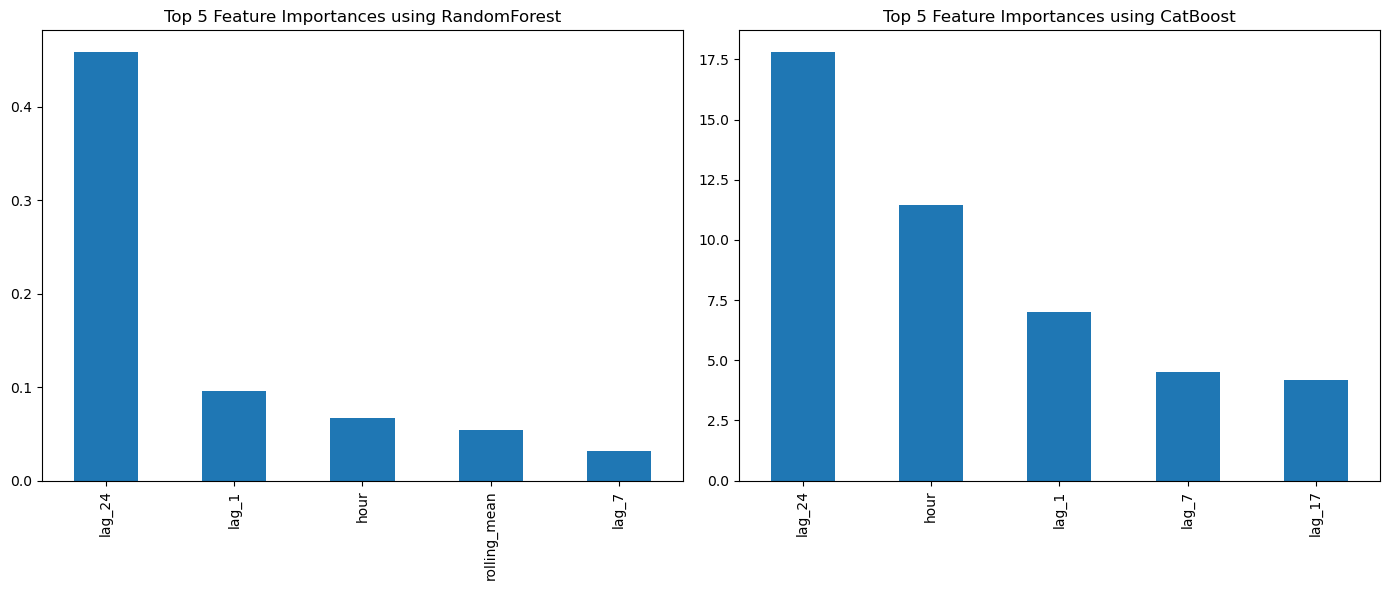

In [122]:
# Feature importance for RandomForest
importances_rf = models["Random Forest"].feature_importances_
feature_importances_rf = pd.Series(importances_rf, index=X_train.columns).sort_values(ascending=False).head(5)

# Feature importance for CatBoost
importances_cb = models["CatBoost"].feature_importances_
feature_importances_cb = pd.Series(importances_cb, index=X_train.columns).sort_values(ascending=False).head(5)

# Plot feature importances
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
feature_importances_rf.plot(kind='bar', title='Top 5 Feature Importances using RandomForest')
plt.subplot(1, 2, 2)
feature_importances_cb.plot(kind='bar', title='Top 5 Feature Importances using CatBoost')
plt.tight_layout()
plt.show()

# Print the top 5 feature importances for both models
print("\nTop 5 Feature Importances using RandomForest:")
for feature, importance in feature_importances_rf.items():
    print(f"{feature}: {importance:.4f}")

print("\nTop 5 Feature Importances using CatBoost:")
for feature, importance in feature_importances_cb.items():
    print(f"{feature}: {importance:.4f}")

From these results:

- Both models identify lag_24 as the most important feature, which is very indicative of a 24-hour cycle in taxi order patterns, likely linked to people's daily routines.
- The importance of the hour feature in both models indicates that demand fluctuates predictably throughout the day (e.g., rush hours).
- The presence of multiple lag features in the top rankings for both models suggests that past values are strong predictors for future demand, a common characteristic of time series data.
- The RandomForest model's focus on the most recent lag (lag_1) implies an emphasis on very short-term trends, while CatBoost's distribution of importance across several lags may indicate a more complex interaction with past data points over different time frames.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Good points! Indeed, looking at feature importances helps us better understand the models

</div>

# Conclusion

We developed a predictive model to forecast the number of taxi orders at airports for the next hour. This was aimed at helping the Sweet Lift Taxi company attract more drivers during peak hours and effectively meet the demand.

Data Preparation and Feature Engineering:

- The historical data on taxi orders was resampled by one hour to align with the prediction goal.
- New features were engineered to capture temporal patterns, including hour of the day, day of the week, and lag features representing past order values, as well as rolling averages to smooth out short-term fluctuations.

Model Selection and Training:

- A variety of models were trained and evaluated, including Linear Regression, Random Forest, CatBoost, Ridge Regression, and Lasso Regression.
- Feature scaling was applied to ensure that models sensitive to feature magnitude could interpret the features appropriately.

Model Evaluation:

- The models were assessed using the Root Mean Squared Error (RMSE) metric on a test set constituting 10% of the initial dataset.
- The performance target was an RMSE not exceeding 48 on the test set.

Results:

- The CatBoost model achieved the lowest RMSE, indicating its strong predictive performance for this particular task. This model was able to effectively leverage both the numerical and categorical features to capture complex patterns in the data.
- RandomForest and Decision Tree models also performed well but did not surpass the CatBoost model. The linear models (Linear Regression, Ridge, and Lasso) did not perform as well, which could be due to their inability to capture the non-linear relationships present in the data.
- Feature importance analysis revealed that past values (specifically 24 hours prior) were highly indicative of future demand, emphasizing the cyclical nature of taxi order volumes.

The project successfully demonstrated the feasibility of predicting taxi demand using machine learning models. It highlighted the importance of temporal features and past order values in forecasting demand. The Sweet Lift Taxi company can use these insights to optimize driver allocation and meet customer needs more effectively, enhancing their operational efficiency and customer satisfaction.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Nice summary!

</div>

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48